### Problem3

In this problem, you are asked to use CNN. By doing this to recognize the given sign language, we hope that you are getting familiar with the CNN algorithm. We have the images of sign language from 0 to 5.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import cPickle

/Users/GYUNAM/.pyenv/versions/3.4.5/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
from six.moves import cPickle
image_set_train = cPickle.load(open('./data_files/image_set_train.pkl', 'rb'))
label_train = cPickle.load(open('./data_files/label_train.pkl', 'rb'))
image_set_test = cPickle.load(open('./data_files/image_set_test.pkl', 'rb'))
label_test = cPickle.load(open('./data_files/label_test.pkl', 'rb'))

In [3]:
np.array(image_set_test).shape

(337, 100, 100)

In [4]:
np.array(label_test).shape

(337, 6)

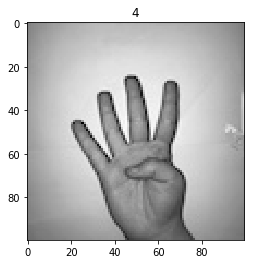

In [5]:
idx = np.random.randint(len(image_set_train))
plt.imshow(image_set_train[idx],'gray')
plt.title(np.argmax(label_train[idx]))
plt.show()

In [6]:
input_h = 100 # Input height
input_w = 100 # Input width
input_ch = 1 # Input channel : Gray scale


## First convolution layer
# Filter size
k1_h = 3
k1_w = 3
# the number of channels
k1_ch = 32
# Pooling size
p1_h = 2
p1_w = 2
# (None, 14, 14 ,32)

## Second convolution layer
# Filter size
k2_h = 3
k2_w = 3
# the number of channels
k2_ch = 64
# Pooling size
p2_h = 2
p2_w = 2
# (None, 7, 7 ,64)

## Fully connected
# Flatten the features
# -> (None, 7*7*64)
conv_result_size = int((input_h/(p1_h*p2_h)) * (input_w/(p1_w*p2_w)) * k2_ch)
n_hidden1 = 100
n_output = 6

In [7]:

weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch],stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch],stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([conv_result_size, n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_hidden1, n_output], stddev = 0.1))
}

biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev = 0.1))
}

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [8]:
# Define Network
def net(x, weights, biases):
    ## First convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, 
                           ksize = [1, p1_h, p1_w, 1], 
                           strides = [1, p1_h, p1_w, 1], 
                           padding = 'VALID'
                           )
    
    ## Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], 
                         strides= [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, 
                           ksize = [1, p2_h, p2_w, 1], 
                           strides = [1, p2_h, p2_w, 1], 
                           padding = 'VALID')

    # shape = conv2.get_shape().as_list()
    # maxp2_re = tf.reshape(conv2, [-1, shape[1]*shape[2]*shape[3]])
    maxp2_re = tf.reshape(maxp2, [-1, conv_result_size])
    
    ### Fully connected
    hidden1 = tf.add(tf.matmul(maxp2_re, weights['hidden1']), biases['hidden1'])
    hidden1 = tf.nn.relu(hidden1)
    output = tf.add(tf.matmul(hidden1, weights['output']), biases['output'])
    return output

In [9]:

LR = 0.0001

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [10]:
n_batch = 50
n_iter = 2500
n_prt = 250


In [11]:
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    idx = np.random.randint(len(label_train), size=n_batch)
    train_x = [image_set_train[i] for i in idx]
    train_y = [label_train[i] for i in idx]
    train_x = np.reshape(np.array(train_x),(-1,100,100,1)) 
    sess.run(optm, feed_dict={x: train_x,  y: train_y})
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x, y: train_y})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 1200.4638671875
Iter : 250
Cost : 13.942736625671387
Iter : 500
Cost : 3.4375829696655273
Iter : 750
Cost : 1.1560593843460083
Iter : 1000
Cost : 2.4341638891201e-06
Iter : 1250
Cost : 0.0
Iter : 1500
Cost : 0.0
Iter : 1750
Cost : 0.0
Iter : 2000
Cost : 0.0
Iter : 2250
Cost : 2.38418573772492e-09


In [12]:
size = 100
idx = np.random.randint(len(label_test), size=size)
test_x = [image_set_test[i] for i in idx]
test_y = [label_test[i] for i in idx]

my_pred = sess.run(pred, feed_dict={x : np.array(test_x).reshape(-1,100,100,1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

Accuracy : 80.0%


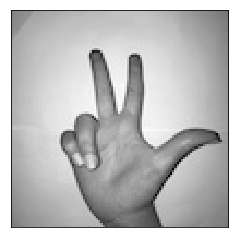

Label : 3
Prediction : 3


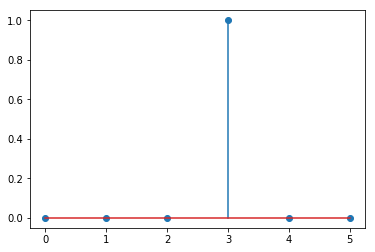

Probability : [0. 0. 0. 1. 0. 0.]


In [13]:
size = 1
idx = np.random.randint(len(label_test), size=size)
test_x = [image_set_test[i] for i in idx]
test_y = [label_test[i] for i in idx]
logits = sess.run(tf.nn.softmax(pred), feed_dict={x : np.array(test_x).reshape(-1,100,100,1)})
predict = np.argmax(logits)

plt.imshow(test_x[0], 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

print('Label : {}'.format(np.argmax(test_y[0])))
print('Prediction : {}'.format(predict))

plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision=2, suppress=True)
print('Probability : {}'.format(logits.ravel()))